#pix2pix는 한 이미지를 다른 이미지로 픽셀 단위로 변화한다는 의미입니다.  스케치된 사진에 색칠해주기 
한방향으로만 변환가능
#cyclegan cyclic하게 변화시킵니다. 양방향으로 이미지 변환가능 스스로 학습을 해서 데이터를 구하기 쉽고 라벨을 붙일 필요가 없음 
#neural style transfer:  이미지 스타일을 변환시킵니다. 

In [ ]:
# 모듈불러오기 

In [2]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.2.0


In [4]:
#gan은 라벨이 필요하지 않습니다. 
#데이터 불러오기 
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_x,_),(tst_x,_) = fashion_mnist.load_data()

In [5]:
# 데이터 확인하기 
print('max pixel:', train_x.max())
print('min pixel:', train_x.min())

max pixel: 255
min pixel: 0


In [6]:
#데이터 정규화 시키기 [-1,1]로 정규화를 시킵니다. 
train_x = (train_x -127.5)/127.5

print('max pixel:', train_x.max())
print('min pixel:', train_x.min())

max pixel: 1.0
min pixel: -1.0


In [7]:
#데이터 셋의 shape을 확인합니다. 
train_x.shape #test set이 1만장이었으니깐요. 그리고 이미지 사이즈도 28*28이니 정상적이네요. 

(60000, 28, 28)

In [8]:
# cnn은 채널수 차원이 필요하기 때문에 차원을 넣어줍니다. 
train_x = train_x.reshape(train_x.shape[0],28,28,1).astype('float32')
train_x.shape

(60000, 28, 28, 1)

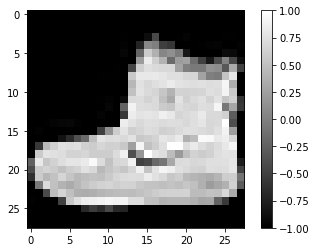

In [10]:
#데이터를 꺼내서 확인해보기 
plt.imshow(train_x[0].reshape(28,28),cmap='gray')
plt.colorbar() # 각 픽셀의 값과 그에 따른 색 확인이 가능합니다. 
plt.show()

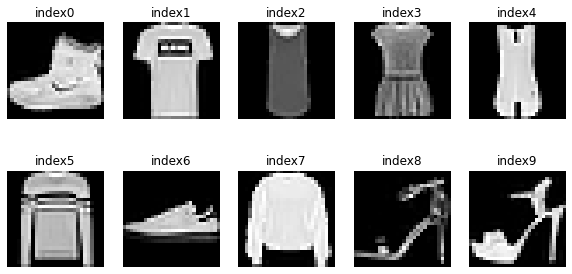

In [11]:
#여러개의 데이터를 확인합니다. 

plt.figure(figsize=(10,5))

for i in range(10):
    plt.subplot(2,5,i+1) # row, col,index 순서입니다. 
    plt.imshow(train_x[i].reshape(28,28),cmap='gray')
    plt.title(f'index{i}')
    plt.axis('off') #불필요한 축을 제거합니다.
plt.show()

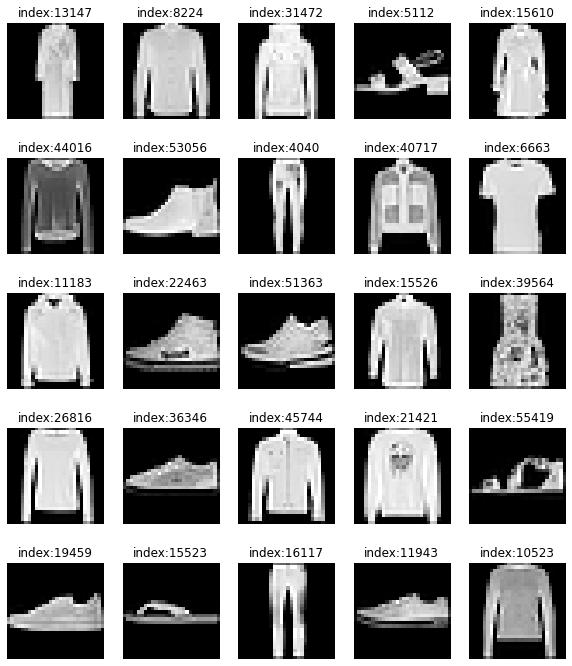

In [19]:
# for문을 통해서 5*5배열로 만들기 
plt.figure(figsize=(10,12))

for i in range(25):
    plt.subplot(5,5,i+1)
    random_index = np.random.randint(1,60000)
    plt.imshow(train_x[random_index].reshape(28,28),cmap='gray')
    plt.title(f'index:{random_index}')
    plt.axis('off')
plt.show()

In [20]:
BUFFER_SIZE = 60000 #전체 데이터를 섞기 위해 6만장으로 설정합니다.  
BATCH_SIZE = 256 #모델이 한 번에 학습할 데이터의 양입니다. 
#너무 많은 양을 한번에 학습시키면 메모리 활용면에서 비효율적이고 한 번 학습하는데 시간이 오래 걸립니다. 이게 미니배치입니다. 
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

#from tensor slices()함수를 사용하면 텐서자료형으로 데이터셋을 만들 수 있습니다. 
#shuffle()함수가 잘 섞어줍니다. 

#오 gan이다!ㅎ

#GAN은 2014년 ian goodfellow
#GAN은 2가지 네트워크가 있음 
#생성자: 아무 의미없는 랜덤 노이즈로부터 신경망에서의 연산을 통해 이미지 향상의 벡터를 생성합니다. m
#판별자: 기존에 있던 진짜 이미지와 생성자가 만들어낸 이미지를 입력받아 각 이미지가 real인지 fake인지 판단 정도를 실숫값으로 출력합니다. 

![image](https://user-images.githubusercontent.com/68840414/109126188-57627b80-7790-11eb-88ae-2d487bd134db.png)
노이즈에서 fake image를 생성하는 생성자와 학습된 이미지를 잘 알고 있는 판별자에게 가서 진짜인지 아닌지 최종결정은 판별자가 하는 구조입니다. 

DCGAN convolution layer를 활용했습니다. 
input 균등분포에서 생성된 100개의 난수

In [25]:
def make_generator_model():#생성자를 생성할 수 있도록 합니다. 

    # Start
    model = tf.keras.Sequential()# 모델을 생성해서 층을 쌓습니다. 

    # First: Dense layer
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization()) #층이 폭발하지 않도록 가중치 값을 정규화시켜줍니다. 
    model.add(layers.LeakyReLU())#리키렐루를 사용하였습니다. 

    # Second: Reshape layer
    model.add(layers.Reshape((7, 7, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(1, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))# 정규화를 -1 ~ 1사이로 정규화를 시켰던 데이터 셋과 동일하게 하기 위함입니다. 

    return model

In [26]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

In [27]:
noise = tf.random.normal([1, 100])

In [28]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 28, 28, 1])

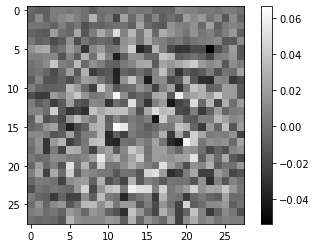

In [29]:
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()

In [30]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [31]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

In [32]:
decision = discriminator(generated_image, training=False)
decision # 판별자함수에 넣으니 아무런 의미가 없는 값이 출력되었습니다. 

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00313711]], dtype=float32)>

In [33]:
#GAN의 손실함수는 cross entropy를 사용합니다. 분류모델을 할 때 많이 사용합니다. 가짜인지 진짜인지 판별해야하니깐 binary cross entropy를 손실함수로 쓴다. 
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [34]:
vector = [[1, 2, 3],
          [4, 5, 6]]

tf.ones_like(vector)

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 1, 1],
       [1, 1, 1]], dtype=int32)>

In [35]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [36]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [37]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [38]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [39]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [40]:
import numpy as np
import tensorflow as tf

def f(x, y):
  print(type(x))
  print(type(y))
  return x ** 2 + y

x = np.array([2, 3])
y = np.array([3, -2])
f(x, y)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


array([7, 7])

In [41]:
import numpy as np
import tensorflow as tf

@tf.function    # 위와 동일한 함수이지만 @tf.function 데코레이터가 적용되었습니다.
def f(x, y):
  print(type(x))
  print(type(y))
  return x ** 2 + y

x = np.array([2, 3])
y = np.array([3, -2])
f(x, y)

<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>


<tf.Tensor: shape=(2,), dtype=int64, numpy=array([7, 7])>

In [42]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [43]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    plt.savefig('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [44]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [45]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [46]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [47]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

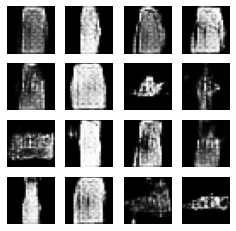

Time for training : 622 sec


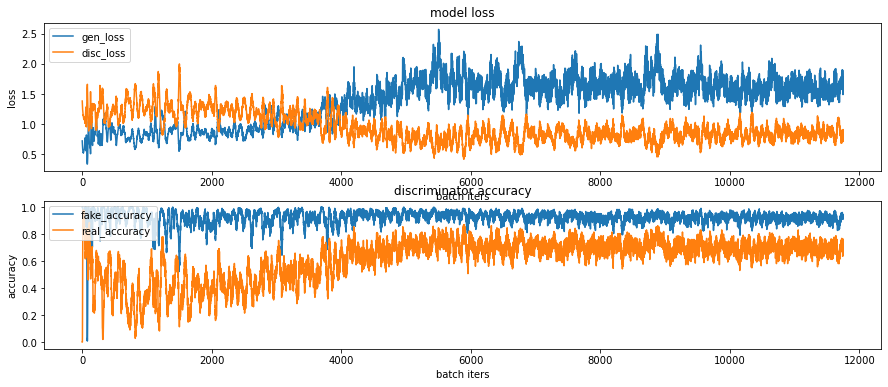

CPU times: user 4min 27s, sys: 12.9 s, total: 4min 40s
Wall time: 10min 23s


In [48]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

In [ ]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif